PA2 Notebook 1: Fetch Data
===


This is the first notebook for DRWI Pollution Assessment Stage 2 (PA2) analysis.
It fetches and prepares all the input data and modeling necessary for the Stage 2 Assessment.

The general data fectching pipeline is to:
- Run Model My Watershed (MMW) Multi-Year Model (GWLF-E)
  -  for every HUC12 in DRWI.
- Proccess MMW HUC12 results through [WikiSRAT microservice](https://github.com/TheAcademyofNaturalSciences/WikiSRATMicroService) API.
  - WikiSRAT downscales HUC12 loads to NHD+v2 catchments and route pollution through the NHD+v2 stream reach network. 
  - WikiSRAT runs group MMW HUC12 results by HUC8 to properly route loads through the stream network.
  - Stream network routing includes attenuation due to physical and biological processes within surface waters. 
  - WikiSRAT gets run multiple times to simulate:
    - Baseline results, with no restoration or protection practices.
    - Restoration results, which include 3 run groups
    - Protection results
- Read, organize, and save combined results for PA2 analysis calculations (Notebook 2).

# Installation and Setup

Carefully follow our **[Installation Instructions](README.md#get-started)**, especially including:
- Creating a virtual environment for this repository (step 3)

## Import Python Dependencies

In [1]:
from pathlib import Path

import numpy as np
import pandas as pd
import geopandas as gpd

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
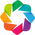

In [2]:
# Custom functions for Pollution Assessment
import pollution_assessment as pa

### If you get `ModuleNotFoundError`:

If you get this error:
```python
ModuleNotFoundError: No module named 'pollution_assessment'
```
Then:
1. Run the following terminal command with your local absolute path to this repo.
    - NOTE: Here we use Jupyter `!` magic command to run from the terminal via this notebook. 
2. Restart the kernel.
3. Rerun the import statements above.

See [Step 4 in the Installation Instructions](#4-add-your-repos-path-to-miniconda-site-packages).

In [3]:
!conda develop /Users/aaufdenkampe/Documents/Python/pollution-assessment/src

path exists, skipping /Users/aaufdenkampe/Documents/Python/pollution-assessment/src
completed operation for: /Users/aaufdenkampe/Documents/Python/pollution-assessment/src


In [4]:
# Confirm that sub-modules are imported
dir(pa)

['__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 '__version__',
 'calc',
 'dynamic_plot',
 'make_map',
 'plot',
 'plot_protected_land',
 'summary_stats',
 'v2_plots']

In [5]:
# Confirm functions within a module
dir(pa.plot)

['CalcMinMax',
 'Extent_Map',
 'FormatAxes',
 'LatLonExtent',
 'LatLonExtent_FA',
 'LogNorm',
 'MidPointLogNorm',
 'Path',
 'PlotMaps',
 'PlotMaps_FA_single_pane',
 'PlotZoom',
 'Polygon',
 'ScaleBar',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 'add_basemap',
 'add_colorbar',
 'calc',
 'cc',
 'color_normalization_bounds',
 'ctx',
 'gpd',
 'hv',
 'matplotlib',
 'np',
 'pd',
 'plot_FA_boundaries',
 'plot_protec_nat',
 'plot_remaining_work',
 'plot_remaining_work_dif',
 'plt',
 'remove_negatives',
 'set_transparent',
 'sine_combs',
 'swatch',
 'swatches']

## Set Paths to Input and Output Files with `pathlib`

Use the [pathlib](https://docs.python.org/3/library/pathlib.html) library (built-in to Python 3) to manage paths indpendentely of OS or environment.

This blog post describes `pathlib`'s benefits relative to using the `os` library or manual approaches.
- https://medium.com/@ageitgey/python-3-quick-tip-the-easy-way-to-deal-with-file-paths-on-windows-mac-and-linux-11a072b58d5f

In [6]:
# Find your current working directory, which should be folder for this notebook.
Path.cwd()

PosixPath('/Users/aaufdenkampe/Documents/Python/pollution-assessment/stage2')

In [7]:
# Set your project directory to your local folder for your clone of this repository
project_path = Path.cwd().parent
project_path

PosixPath('/Users/aaufdenkampe/Documents/Python/pollution-assessment')

In [8]:
# Assign a path for PA21 data INPUT folders. 
# For folders, end with a slash character, `/`.
pa1_data_path = project_path / 'stage1/data/'

In [9]:
# Assign relative paths for PA2 data INPUT folders. 
pa2_mmw_folder  = Path('stage2/DRB_GWLFE/mmw_results/')
pa2_wikisrat_folder = Path('stage2/wikiSRAT/')

# Uncommment to test WikiSRAT files from Oct 27 
# (committed on Sept 26) https://github.com/WikiWatershed/pollution-assessment/commit/d79d7d1d68a9f3a96238c1d6cbedd7ba045a4597
# pa2_wikisrat_folder = Path('stage2/wikiSRAT_oct27/')

In [10]:
# Assign a path for the geographies folder.
geography_path = project_path / 'geography/'

In [11]:
# Assign a path for the data OUTPUT folder.
data_output_path = project_path / 'stage2/data_output/'

# PA2 Names & Units

## PA2 File Naming Conventions
NOTE: For Stage 2 we changed naming slightly from Stage 1, to better facilitate building various options.

Level 1 names, scale:
* `reach` indicates reach-level data, which includes all upstream contributions
* `catch` indicates catchment-level data, for the local catchment only

Level 2 names, model:
* `_base` indicates model baseline outputs (no conservation)
* `_rest` indicates model with restoration reductions
* `_prot` indicates model with protection projects, avoided loads

**Clusters** are geographic priority areas, which include parts of pristine headwaters and working forests of the upper watershed, farmlands, suburbs, and industrial and urban centers downstream, and the coastal plain where the river and emerging groundwater empties into either the Delaware Bay or the Atlantic Coast.

There are 8 included in the DRB:
- Poconos-Kittaninny, 
- Upper Lehigh,  
- New Jersey Highlands, 
- Middle Schuylkill, 
- Schuylkill Highlands, 
- Upstream Suburban Philadelphia, 
- Brandywine-Christina, 
- Kirkwood-Cohansey Aquifer. 

**Focus areas** are smaller geographic units within clusters. 

# Create GeoDataframes for COMID Catchment & Reach Geometries
Read Stage 1 dataframes to get the COMIDs & geometries for NHD+v2 catchments and reaches, as a foundation for all Stage 2 work

- Background: stage1/WikiSRAT_AnalysisViz.ipynb
- Parquet to GeoDataFrame: https://geopandas.readthedocs.io/en/latest/docs/reference/api/geopandas.read_parquet.html

## Read Stage 1 GeoDataFrames w/ COMID geometries

In [12]:
%%time
# read data from parquet files
catch_gdf = gpd.read_parquet(pa1_data_path /'base_df_catch.parquet')
reach_gdf = gpd.read_parquet(pa1_data_path /'base_df_reach.parquet')

CPU times: user 495 ms, sys: 136 ms, total: 631 ms
Wall time: 598 ms


In [13]:
catch_gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 19496 entries, 1748535 to 932040370
Data columns (total 19 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   tp_load             19496 non-null  float64 
 1   tn_load             19496 non-null  float64 
 2   tss_load            19496 non-null  float64 
 3   catchment_hectares  19496 non-null  float64 
 4   watershed_hectares  19496 non-null  float64 
 5   tp_loadrate_ws      19496 non-null  float64 
 6   tn_loadrate_ws      19496 non-null  float64 
 7   tss_loadrate_ws     19496 non-null  float64 
 8   maflowv             19496 non-null  float64 
 9   geom_catchment      19496 non-null  geometry
 10  cluster             17358 non-null  category
 11  sub_focusarea       186 non-null    Int64   
 12  nord                18870 non-null  Int64   
 13  nordstop            18844 non-null  Int64   
 14  huc12               19496 non-null  category
 15  streamorder         194

In [14]:
reach_gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 19496 entries, 1748535 to 932040370
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   tp_conc             16823 non-null  float64 
 1   tn_conc             16823 non-null  float64 
 2   tss_conc            16823 non-null  float64 
 3   catchment_hectares  19496 non-null  float64 
 4   watershed_hectares  19496 non-null  float64 
 5   maflowv             19496 non-null  float64 
 6   geom                19494 non-null  geometry
 7   cluster             17358 non-null  category
 8   sub_focusarea       186 non-null    Int64   
 9   nord                18870 non-null  Int64   
 10  nordstop            18844 non-null  Int64   
 11  huc12               19496 non-null  category
 12  streamorder         19496 non-null  int64   
 13  headwater           19496 non-null  int64   
 14  phase               4082 non-null   category
 15  fa_name             408

## Remove Stage 1 results

In [15]:
pa1_catch_vars = ['tp_load', 'tn_load', 'tss_load',
    'tp_loadrate_ws', 'tn_loadrate_ws', 'tss_loadrate_ws',
]
catch_gdf.drop(pa1_catch_vars, axis='columns', inplace=True)

In [16]:
pa1_reach_vars = ['tp_conc', 'tn_conc', 'tss_conc',]
reach_gdf.drop(pa1_reach_vars, axis='columns', inplace=True)

## Rename Geometry
Apparently, in GeoViews, the geometry column **must** be named 'geometry', otherwise get an error. Sarah found that solve in [this discussion](https://github.com/holoviz/geoviews/issues/506). 

GeoPandas >=0.12 appears to require a special `gdf.rename_geometry()` function, rather than the generic rename column function.

In [17]:
reach_gdf.geometry.name

'geom'

In [18]:
catch_gdf.geometry.name

'geom_catchment'

In [19]:
reach_gdf.rename_geometry("geometry", inplace=True)
catch_gdf.rename_geometry("geometry", inplace=True)

In [20]:
reach_gdf.geometry.name

'geometry'

In [21]:
catch_gdf.geometry.name

'geometry'

## Add HUC8 and DRB tags to each COMID

In [22]:
# Read HUC08 tags from list of COMIDs in HUC04='0204'
temp_df = pd.read_csv(pa1_data_path /'comids0204_in_drb.csv',
                      index_col='comid',
                      dtype={ #'in_drb': 'category',  # keep as string object, to convert to boolean
                             'huc08': 'category',
                            }
                     )
temp_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 21837 entries, 6261932 to 8409259
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype   
---  ------  --------------  -----   
 0   in_drb  21837 non-null  object  
 1   huc08   21837 non-null  category
dtypes: category(1), object(1)
memory usage: 363.2+ KB


In [23]:
# Convert 'in_drb' to boolean
temp_df.in_drb = temp_df.in_drb.copy().map({
    't': True,
    'f': False,
}).astype('boolean')

In [24]:
temp_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 21837 entries, 6261932 to 8409259
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype   
---  ------  --------------  -----   
 0   in_drb  21837 non-null  boolean 
 1   huc08   21837 non-null  category
dtypes: boolean(1), category(1)
memory usage: 235.3 KB


In [25]:
# Add columns to df
vars = ['in_drb','huc08']

reach_gdf[vars] = temp_df[vars]
catch_gdf[vars] = temp_df[vars]

### Confirm counts

In [26]:
temp_df.in_drb.value_counts()

in_drb
True     16033
False     5804
Name: count, dtype: Int64

In [27]:
# Confirm that no DRB stream reaches are dropped
reach_gdf.in_drb.value_counts()

in_drb
True     16033
False     3463
Name: count, dtype: Int64

In [28]:
temp_df.huc08.unique()

['02040301', '02040302', '02040303', '02040304', '02040101', ..., '02040203', '02040204', '02040205', '02040206', '02040207']
Length: 17
Categories (17, object): ['02040101', '02040102', '02040103', '02040104', ..., '02040301', '02040302', '02040303', '02040304']

In [29]:
reach_gdf.huc08.unique()

['02040102', '02040105', '02040101', '02040104', '02040103', ..., '02040207', '02040303', '02040302', '02040301', '02040206']
Length: 16
Categories (17, object): ['02040101', '02040102', '02040103', '02040104', ..., '02040301', '02040302', '02040303', '02040304']

## Add HUC10 tags to each COMID

In [30]:
# Convert huc12 to string, strip right 2 characters, and convert back to categorical
reach_gdf['huc10'] = reach_gdf.huc12.astype('str').str[:-2].astype(pd.CategoricalDtype())
catch_gdf['huc10'] = catch_gdf.huc12.astype('str').str[:-2].astype(pd.CategoricalDtype())

In [31]:
reach_gdf['huc10']

comid
1748535      0204010203
1748537      0204010203
1748539      0204010203
1748541      0204010203
1748543      0204010203
                ...    
932040366    0204020601
932040367    0204020601
932040368    0204020601
932040369    0204020400
932040370    0204020601
Name: huc10, Length: 19496, dtype: category
Categories (96, object): ['0204010101', '0204010102', '0204010103', '0204010104', ..., '0204030202', '0204030203', '0204030204', '0204030301']

# Read Geography Geometry files

## DRWI Clusters & Focus Areas

In [32]:
# Read DRWI geometries from PA1
cluster_gdf = gpd.read_parquet(pa1_data_path / 'cluster_df.parquet')

focusarea_gdf = gpd.read_parquet(pa1_data_path /'fa_phase2_df.parquet')
focusarea_gdf.cluster = focusarea_gdf.cluster.replace('Kirkwood Cohansey Aquifer', 'Kirkwood - Cohansey Aquifer') # update name for consistency with other files 
focusarea_gdf.set_index('name', inplace=True)

## HUC12s in DRWI

### HUC12 Part 1: Build base
This workflow has been moslty moved to `geography/huc12_reach_analysis.ipynb`, which produces `huc12s_in_and_outflows_gdf.parquet`.

In [33]:
huc12_outlets_gdf = gpd.read_parquet(
        geography_path / 'huc12s_in_and_outflows_gdf.parquet',
) 
huc12_outlets_gdf.huc12_name = huc12_outlets_gdf.huc12_name.astype(pd.CategoricalDtype())
huc12_outlets_gdf.info()
huc12_outlets_gdf.head(5)

<class 'geopandas.geodataframe.GeoDataFrame'>
CategoricalIndex: 538 entries, 020401010101 to 020403040502
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   huc12_name     538 non-null    category
 1   geometry       538 non-null    geometry
 2   centroid_xy    538 non-null    object  
 3   comid          523 non-null    Int64   
 4   nord           523 non-null    Int64   
 5   to_huc12       523 non-null    category
 6   outlet_comid   523 non-null    Int64   
 7   from_huc12s    249 non-null    object  
 8   inlet_comids   249 non-null    object  
 9   outlet_comids  538 non-null    object  
dtypes: Int64(3), category(2), geometry(1), object(4)
memory usage: 89.2+ KB


,huc12_name,geometry,centroid_xy,comid,nord,to_huc12,outlet_comid,from_huc12s,inlet_comids,outlet_comids
huc12,,,,,,,,,,
020401010101,Town Brook-Headwaters West Brach Delaware River,"POLYGON ((-74.59363 42.42361, -74.59395 42.423...","[-74.62155936289159, 42.387091234041016]",2612792,74293,020401010102,2612792,None,None,[2612792]
020401010102,Betty Brook-Headwaters West Brach Delaware River,"POLYGON ((-74.69614 42.42722, -74.69579 42.427...","[-74.71393635968639, 42.38194565669812]",2612800,74290,020401010103,2612800,[020401010101],[2612792],"[2612800, 2612922]"
020401010103,Rose Brook-Headwaters West Brach Delaware River,"POLYGON ((-74.77568 42.37921, -74.77530 42.379...","[-74.71097819143394, 42.330665690562654]",2612808,74288,020401010104,2612808,[020401010102],[2612800],[2612808]
020401010104,Elk Creek-Headwaters West Brach Delaware River,"POLYGON ((-74.80026 42.40748, -74.79917 42.407...","[-74.82334627464569, 42.34506256688788]",2612820,74282,020401010106,2612820,[020401010103],[2612808],[2612820]
020401010105,Upper Little Delaware River,"POLYGON ((-74.73673 42.31516, -74.73631 42.315...","[-74.78436638151948, 42.27096486797448]",2612842,74311,020401010106,2612842,None,None,[2612842]


In [34]:
# Create HUC12 GDF filtered for DRWI only
huc12_outlets_drwi_gdf = huc12_outlets_gdf.loc[reach_gdf.huc12.unique()]
huc12_outlets_drwi_gdf.sort_index(inplace=True)
huc12_outlets_drwi_gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
CategoricalIndex: 484 entries, 020401010101 to 020403030101
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   huc12_name     484 non-null    category
 1   geometry       484 non-null    geometry
 2   centroid_xy    484 non-null    object  
 3   comid          481 non-null    Int64   
 4   nord           481 non-null    Int64   
 5   to_huc12       481 non-null    category
 6   outlet_comid   481 non-null    Int64   
 7   from_huc12s    231 non-null    object  
 8   inlet_comids   231 non-null    object  
 9   outlet_comids  484 non-null    object  
dtypes: Int64(3), category(2), geometry(1), object(4)
memory usage: 85.3+ KB


In [35]:
# Explore null COMIDs
gdf = huc12_outlets_drwi_gdf[huc12_outlets_drwi_gdf.outlet_comid.isnull()]
gdf

,huc12_name,geometry,centroid_xy,comid,nord,to_huc12,outlet_comid,from_huc12s,inlet_comids,outlet_comids
huc12,,,,,,,,,,
020402070605,Breakwater Harbor-Delaware Bay,"POLYGON ((-75.09484 38.80573, -75.09482 38.805...","[-75.1767156817287, 38.8273442407868]",<NA>,<NA>,NaN,<NA>,None,None,[]
020403020408,Great Egg Harbor Bay-Great Egg Harbor Inlet,"POLYGON ((-74.51911 39.39804, -74.51880 39.397...","[-74.55593928800339, 39.327626573083464]",<NA>,<NA>,NaN,<NA>,None,None,[]
020403030101,Wolfe Glade-Rehoboth Canal,"POLYGON ((-75.08011 38.74036, -75.08026 38.739...","[-75.114143485874, 38.75904341704546]",<NA>,<NA>,NaN,<NA>,None,None,[]


In [36]:
# Select COMIDs based on larger `watershed_hectares`?
# DECISION: NO
reach_gdf.loc[reach_gdf.huc12.isin(gdf.index)].sort_values(['huc12','watershed_hectares']).head()

,catchment_hectares,watershed_hectares,maflowv,geometry,cluster,sub_focusarea,nord,nordstop,huc12,streamorder,headwater,phase,fa_name,in_drb,huc08,huc10
comid,,,,,,,,,,,,,,,,
8409233,104.9463,105.03,0.439,MULTILINESTRING Z ((491007.244 4292985.904 0.0...,NaN,<NA>,<NA>,<NA>,020402070605,0,0,NaN,NaN,True,02040207,0204020706
8409515,120.1440,120.24,0.504,MULTILINESTRING Z ((492334.335 4293850.256 0.0...,NaN,<NA>,<NA>,<NA>,020402070605,0,0,NaN,NaN,True,02040207,0204020706
9437217,0.4497,0.45,0.001,MULTILINESTRING Z ((532184.744 4345020.691 0.0...,NaN,<NA>,<NA>,<NA>,020403020408,0,0,NaN,NaN,False,02040302,0204030204
26814149,0.7194,0.72,0.002,MULTILINESTRING Z ((532250.220 4344988.940 0.0...,NaN,<NA>,<NA>,<NA>,020403020408,0,0,NaN,NaN,False,02040302,0204030204
9436867,2.7878,2.79,0.011,MULTILINESTRING Z ((531869.300 4351093.754 0.0...,NaN,<NA>,<NA>,<NA>,020403020408,0,0,NaN,NaN,False,02040302,0204030204


In [37]:
# Drop HUC12's with missing COMID
huc12_outlets_drwi_gdf.dropna(subset=['comid'], inplace=True)

# Recast from 'int64' to nullable pd.Int64Dtype(), if necessary
# huc12_outlets_drwi_gdf.outlet_comid = huc12_outlets_drwi_gdf.outlet_comid.astype(np.int64)

huc12_outlets_drwi_gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
CategoricalIndex: 481 entries, 020401010101 to 020403020407
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   huc12_name     481 non-null    category
 1   geometry       481 non-null    geometry
 2   centroid_xy    481 non-null    object  
 3   comid          481 non-null    Int64   
 4   nord           481 non-null    Int64   
 5   to_huc12       481 non-null    category
 6   outlet_comid   481 non-null    Int64   
 7   from_huc12s    231 non-null    object  
 8   inlet_comids   231 non-null    object  
 9   outlet_comids  481 non-null    object  
dtypes: Int64(3), category(2), geometry(1), object(4)
memory usage: 85.1+ KB


In [38]:
# Add HUC10 & HUC08
# Convert huc12 to string, strip right 2 characters, and convert back to categorical
huc12_outlets_drwi_gdf['huc10'] = huc12_outlets_drwi_gdf.index.astype('str').str[:-2].astype(pd.CategoricalDtype())
huc12_outlets_drwi_gdf['huc08'] = huc12_outlets_drwi_gdf.index.astype('str').str[:-4].astype(pd.CategoricalDtype())

In [39]:
huc12_outlets_drwi_gdf.info()
huc12_outlets_drwi_gdf.head()

<class 'geopandas.geodataframe.GeoDataFrame'>
CategoricalIndex: 481 entries, 020401010101 to 020403020407
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   huc12_name     481 non-null    category
 1   geometry       481 non-null    geometry
 2   centroid_xy    481 non-null    object  
 3   comid          481 non-null    Int64   
 4   nord           481 non-null    Int64   
 5   to_huc12       481 non-null    category
 6   outlet_comid   481 non-null    Int64   
 7   from_huc12s    231 non-null    object  
 8   inlet_comids   231 non-null    object  
 9   outlet_comids  481 non-null    object  
 10  huc10          481 non-null    category
 11  huc08          481 non-null    category
dtypes: Int64(3), category(4), geometry(1), object(4)
memory usage: 89.5+ KB


,huc12_name,geometry,centroid_xy,comid,nord,to_huc12,outlet_comid,from_huc12s,inlet_comids,outlet_comids,huc10,huc08
huc12,,,,,,,,,,,,
020401010101,Town Brook-Headwaters West Brach Delaware River,"POLYGON ((-74.59363 42.42361, -74.59395 42.423...","[-74.62155936289159, 42.387091234041016]",2612792,74293,020401010102,2612792,None,None,[2612792],0204010101,02040101
020401010102,Betty Brook-Headwaters West Brach Delaware River,"POLYGON ((-74.69614 42.42722, -74.69579 42.427...","[-74.71393635968639, 42.38194565669812]",2612800,74290,020401010103,2612800,[020401010101],[2612792],"[2612800, 2612922]",0204010101,02040101
020401010103,Rose Brook-Headwaters West Brach Delaware River,"POLYGON ((-74.77568 42.37921, -74.77530 42.379...","[-74.71097819143394, 42.330665690562654]",2612808,74288,020401010104,2612808,[020401010102],[2612800],[2612808],0204010101,02040101
020401010104,Elk Creek-Headwaters West Brach Delaware River,"POLYGON ((-74.80026 42.40748, -74.79917 42.407...","[-74.82334627464569, 42.34506256688788]",2612820,74282,020401010106,2612820,[020401010103],[2612808],[2612820],0204010101,02040101
020401010105,Upper Little Delaware River,"POLYGON ((-74.73673 42.31516, -74.73631 42.315...","[-74.78436638151948, 42.27096486797448]",2612842,74311,020401010106,2612842,None,None,[2612842],0204010101,02040101


In [40]:
columns = ['in_drb']
huc12_outlets_drwi_gdf = huc12_outlets_drwi_gdf.join(reach_gdf[columns], on='comid')

In [41]:
huc12_outlets_drwi_gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
CategoricalIndex: 481 entries, 020401010101 to 020403020407
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   huc12_name     481 non-null    category
 1   geometry       481 non-null    geometry
 2   centroid_xy    481 non-null    object  
 3   comid          481 non-null    Int64   
 4   nord           481 non-null    Int64   
 5   to_huc12       481 non-null    category
 6   outlet_comid   481 non-null    Int64   
 7   from_huc12s    231 non-null    object  
 8   inlet_comids   231 non-null    object  
 9   outlet_comids  481 non-null    object  
 10  huc10          481 non-null    category
 11  huc08          481 non-null    category
 12  in_drb         481 non-null    boolean 
dtypes: Int64(3), boolean(1), category(4), geometry(1), object(4)
memory usage: 90.5+ KB


In [42]:
huc12_outlets_drwi_gdf.in_drb.value_counts()

in_drb
True     426
False     55
Name: count, dtype: Int64

### HUC12 Part 2: Add Inlet COMIDs
Now done above by reading from `geography/huc12_reach_analysis.ipynb`

In [43]:
# Create base for new final output
huc12_in_outlets_drwi_gdf = huc12_outlets_drwi_gdf

In [44]:
huc12_in_outlets_drwi_gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
CategoricalIndex: 481 entries, 020401010101 to 020403020407
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   huc12_name     481 non-null    category
 1   geometry       481 non-null    geometry
 2   centroid_xy    481 non-null    object  
 3   comid          481 non-null    Int64   
 4   nord           481 non-null    Int64   
 5   to_huc12       481 non-null    category
 6   outlet_comid   481 non-null    Int64   
 7   from_huc12s    231 non-null    object  
 8   inlet_comids   231 non-null    object  
 9   outlet_comids  481 non-null    object  
 10  huc10          481 non-null    category
 11  huc08          481 non-null    category
 12  in_drb         481 non-null    boolean 
dtypes: Int64(3), boolean(1), category(4), geometry(1), object(4)
memory usage: 90.5+ KB


In [45]:
huc12_in_outlets_drwi_gdf

,huc12_name,geometry,centroid_xy,comid,nord,to_huc12,outlet_comid,from_huc12s,inlet_comids,outlet_comids,huc10,huc08,in_drb
huc12,,,,,,,,,,,,,
020401010101,Town Brook-Headwaters West Brach Delaware River,"POLYGON ((-74.59363 42.42361, -74.59395 42.423...","[-74.62155936289159, 42.387091234041016]",2612792,74293,020401010102,2612792,None,None,[2612792],0204010101,02040101,True
020401010102,Betty Brook-Headwaters West Brach Delaware River,"POLYGON ((-74.69614 42.42722, -74.69579 42.427...","[-74.71393635968639, 42.38194565669812]",2612800,74290,020401010103,2612800,[020401010101],[2612792],"[2612800, 2612922]",0204010101,02040101,True
020401010103,Rose Brook-Headwaters West Brach Delaware River,"POLYGON ((-74.77568 42.37921, -74.77530 42.379...","[-74.71097819143394, 42.330665690562654]",2612808,74288,020401010104,2612808,[020401010102],[2612800],[2612808],0204010101,02040101,True
020401010104,Elk Creek-Headwaters West Brach Delaware River,"POLYGON ((-74.80026 42.40748, -74.79917 42.407...","[-74.82334627464569, 42.34506256688788]",2612820,74282,020401010106,2612820,[020401010103],[2612808],[2612820],0204010101,02040101,True
020401010105,Upper Little Delaware River,"POLYGON ((-74.73673 42.31516, -74.73631 42.315...","[-74.78436638151948, 42.27096486797448]",2612842,74311,020401010106,2612842,None,None,[2612842],0204010101,02040101,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...
020403020403,Absecon Bay,"POLYGON ((-74.36191 39.40873, -74.36299 39.407...","[-74.44604887400864, 39.417944290515535]",9436627,125390,020403020408,9436627,[020403020401],[9436775],[],0204030204,02040302,False
020403020404,Cape May Harbor-Cape May Inlet,"POLYGON ((-74.87933 39.01592, -74.87853 39.015...","[-74.8841890564985, 38.973283432181894]",9437503,120596,020403020500,9437503,None,None,"[9437503, 9438907, 9438927]",0204030204,02040302,False
020403020405,Great Channel-Hereford Inlet,"POLYGON ((-74.74022 39.07888, -74.74128 39.077...","[-74.81118396051109, 39.05056352723319]",9438919,123313,020403020500,9438919,None,None,"[9438919, 9438933, 9438959, 9436483]",0204030204,02040302,False


## HUC10s in DRWI

In [46]:
# Get HUC10 Geometries & prepare as basis for calcs & viz
huc10_gdf = gpd.read_parquet(geography_path / 'huc10_0204.parquet')
huc10_gdf.rename(columns={'HUC10':'huc10'}, inplace=True)
huc10_gdf.sort_values('huc10', inplace=True)
huc10_gdf.huc10 = huc10_gdf.huc10.astype(pd.CategoricalDtype(ordered=True))
huc10_gdf.set_index('huc10', inplace=True)
huc10_gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
CategoricalIndex: 155 entries, 0202000502 to 0301020517
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   geometry  155 non-null    geometry
dtypes: geometry(1)
memory usage: 6.8 KB


In [47]:
# Get and prepare HUC10 names (list from Caitlin)
huc10_names_df = pd.read_csv(project_path / 'geography/huc10_names.csv')
# Convert huc10 code from integer to category with leading zero
huc10_list = [str(i).zfill(10) for i in huc10_names_df['HUC10']]
huc10_names_df['huc10'] = pd.DataFrame(huc10_list).astype('category')
huc10_names_df.set_index('huc10', inplace=True)
huc10_names_df.info()

<class 'pandas.core.frame.DataFrame'>
CategoricalIndex: 110 entries, 0204020400 to 0204020603
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   HUC10   110 non-null    int64 
 1   NAME    110 non-null    object
dtypes: int64(1), object(1)
memory usage: 6.8+ KB


In [48]:
huc10_names_df

,HUC10,NAME
huc10,,
0204020400,204020400,Delaware Bay-Deep
0204030306,204030306,Fenwick Island-Assateague Island-Atlantic Ocean
0204020504,204020504,Brandywine Creek
0204010101,204010101,Upper West Branch Delaware River
0204010102,204010102,Middle West Branch Delaware River
...,...,...
0204030205,204030205,Great Egg Harbor Bay-Atlantic Ocean
0204020202,204020202,South Branch Rancocas Creek
0204020601,204020601,Salem River-Delaware River


In [49]:
# Add HUC10 name to GDF
huc10_gdf['huc10_name'] = huc10_names_df['NAME']
huc10_gdf.huc10_name = huc10_gdf.huc10_name.astype(pd.CategoricalDtype())
huc10_gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
CategoricalIndex: 155 entries, 0202000502 to 0301020517
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   geometry    155 non-null    geometry
 1   huc10_name  110 non-null    category
dtypes: category(1), geometry(1)
memory usage: 11.9 KB


In [50]:
# Get COMIDs at HUC10 outlets (list from Mike)
huc10_outlets_df = pd.read_csv(geography_path / 'huc10_outlet_comids.csv',
                               dtype={'huc10': 'category'})
huc10_outlets_df.set_index('huc10', inplace=True)
huc10_outlets_df.info()

<class 'pandas.core.frame.DataFrame'>
CategoricalIndex: 108 entries, 0204010101 to 0204030405
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   comid   108 non-null    int64
 1   nord    108 non-null    int64
dtypes: int64(2)
memory usage: 2.6 KB


In [51]:
columns = ['in_drb', 'huc08']
huc10_outlets_df = huc10_outlets_df.join(reach_gdf[columns], on='comid')

In [52]:
# Add outlet COMIDs & nord
huc10_outlets_gdf = huc10_gdf.loc[:,['huc10_name', 
                                    'geometry',
                                    ]]
huc10_outlets_gdf['comid'] = huc10_outlets_df.comid
huc10_outlets_gdf['nord'] = huc10_outlets_df.nord

huc10_outlets_gdf.sort_index(inplace=True)

In [53]:
# Drop HUC10's outside of DRWI
huc10_outlets_drwi_gdf = huc10_outlets_gdf.dropna().copy()
# Recast to 'int64' from nullable float
huc10_outlets_drwi_gdf.comid = huc10_outlets_drwi_gdf.comid.astype(np.int64)
huc10_outlets_drwi_gdf.nord = huc10_outlets_drwi_gdf.nord.astype(np.int64)


In [54]:
# Add 'in_drb'
columns = ['in_drb', 'huc08']
huc10_outlets_drwi_gdf = huc10_outlets_drwi_gdf.join(reach_gdf[columns], on='comid')

In [55]:
# Drop HUC10s outside DRWI (i.e. 'in_drb'=NA)
huc10_outlets_drwi_gdf.dropna(inplace=True)

In [56]:
huc10_outlets_drwi_gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
CategoricalIndex: 95 entries, 0204010101 to 0204030204
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   huc10_name  95 non-null     category
 1   geometry    95 non-null     geometry
 2   comid       95 non-null     int64   
 3   nord        95 non-null     int64   
 4   in_drb      95 non-null     boolean 
 5   huc08       95 non-null     category
dtypes: boolean(1), category(2), geometry(1), int64(2)
memory usage: 13.7 KB


In [57]:
huc10_outlets_drwi_gdf.in_drb.value_counts()

in_drb
True     86
False     9
Name: count, dtype: Int64

## HUC8s in DRWI

In [58]:
# Read HUC8 Geometries & prepare as basis for calcs & viz
huc08_gdf = gpd.read_parquet(geography_path / 'huc08_0204.parquet')
huc08_gdf.sort_values('huc08', inplace=True)
huc08_gdf.huc08 = huc08_gdf.huc08.astype(pd.CategoricalDtype(ordered=True))
huc08_gdf.set_index('huc08', inplace=True)
huc08_gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
CategoricalIndex: 17 entries, 02040101 to 02040304
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   geometry  17 non-null     geometry
dtypes: geometry(1)
memory usage: 845.0 bytes


In [59]:
# Add HUC08 names (list from Caitlin)
huc08_names_df = pd.read_csv(project_path / 'geography/huc08_names.csv')

In [60]:
# Convert huc08 code from integer to category with leading zero
huc08_list = [str(i).zfill(8) for i in huc08_names_df['HUC08']]
huc08_names_df['huc08'] = pd.DataFrame(huc08_list).astype('category')
huc08_names_df.set_index('huc08', inplace=True)
huc08_names_df.info()

<class 'pandas.core.frame.DataFrame'>
CategoricalIndex: 17 entries, 02040101 to 02040304
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   HUC08   17 non-null     int64 
 1   NAME    17 non-null     object
dtypes: int64(1), object(1)
memory usage: 981.0+ bytes


In [61]:
# Add HUC08 name to GDF
huc08_gdf['huc08_name'] = huc08_names_df['NAME']
huc08_gdf.huc08_name = huc08_gdf.huc08_name.astype(pd.CategoricalDtype())
huc08_gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
CategoricalIndex: 17 entries, 02040101 to 02040304
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   geometry    17 non-null     geometry
 1   huc08_name  17 non-null     category
dtypes: category(1), geometry(1)
memory usage: 1.5 KB


In [62]:
# Get COMIDs at HUC8 outlets (list from Mike)
huc08_outlets_df = pd.read_csv(geography_path / 'huc08_outlet_comids.csv',
                               dtype={'huc08': 'category'})
huc08_outlets_df.set_index('huc08', inplace=True)
huc08_outlets_df.info()

<class 'pandas.core.frame.DataFrame'>
CategoricalIndex: 17 entries, 02040101 to 02040304
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   comid   17 non-null     int64
 1   nord    17 non-null     int64
dtypes: int64(2)
memory usage: 425.0 bytes


In [63]:
# Add outlet COMIDs & nord
huc08_outlets_gdf = huc08_gdf.loc[:,['huc08_name', 'geometry']]
huc08_outlets_gdf['comid'] = huc08_outlets_df.comid
huc08_outlets_gdf['nord'] = huc08_outlets_df.nord

In [64]:
huc08_outlets_gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
CategoricalIndex: 17 entries, 02040101 to 02040304
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   huc08_name  17 non-null     category
 1   geometry    17 non-null     geometry
 2   comid       17 non-null     int64   
 3   nord        17 non-null     int64   
dtypes: category(1), geometry(1), int64(2)
memory usage: 1.8 KB


In [65]:
# Create HUC08 GDF filtered for DRWI only
huc08_outlets_drwi_gdf = huc08_outlets_gdf.loc[reach_gdf.huc08.unique()].copy()
huc08_outlets_drwi_gdf.sort_index(inplace=True)

In [66]:
# Add 'in_drb'
huc08_outlets_drwi_gdf = huc08_outlets_drwi_gdf.join(reach_gdf.in_drb, on='comid')

In [67]:
huc08_outlets_drwi_gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
CategoricalIndex: 16 entries, 02040101 to 02040303
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   huc08_name  16 non-null     category
 1   geometry    16 non-null     geometry
 2   comid       16 non-null     int64   
 3   nord        16 non-null     int64   
 4   in_drb      15 non-null     boolean 
dtypes: boolean(1), category(1), geometry(1), int64(2)
memory usage: 1.8 KB


In [68]:
huc08_outlets_drwi_gdf

,huc08_name,geometry,comid,nord,in_drb
huc08,,,,,
02040101,Upper Delaware,"POLYGON ((-74.59815 42.45806, -74.59793 42.457...",2619256,73297,True
02040102,East Branch Delaware,"POLYGON ((-74.50883 42.35118, -74.50894 42.350...",1752159,74523,True
02040103,Lackawaxen,"POLYGON ((-75.41513 41.80363, -75.41475 41.803...",2741462,72447,True
02040104,Middle Delaware-Mongaup-Brodhead,"POLYGON ((-74.47264 42.03164, -74.47197 42.031...",4154510,70222,True
02040105,Middle Delaware-Musconetcong,"POLYGON ((-74.72652 41.18314, -74.72649 41.182...",4481949,68818,True
02040106,Lehigh,"POLYGON ((-75.41172 41.28606, -75.41113 41.285...",4188251,74985,True
02040201,Crosswicks-Neshaminy,"POLYGON ((-75.10915 40.39567, -75.10832 40.395...",4485575,68274,True
02040202,Lower Delaware,"POLYGON ((-75.05008 40.20041, -75.04930 40.200...",24903452,65081,True
02040203,Schuylkill,"POLYGON ((-75.93681 40.88508, -75.93622 40.884...",4784841,65459,True


In [69]:
huc08_outlets_drwi_gdf.in_drb.value_counts()

in_drb
True     13
False     2
Name: count, dtype: Int64

In [70]:
# Drop last HUC08, which is outside DRWI (i.e. 'in_drb'=NA)
huc08_outlets_drwi_gdf.dropna(inplace=True)

In [71]:

huc08_outlets_drwi_gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
CategoricalIndex: 15 entries, 02040101 to 02040302
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   huc08_name  15 non-null     category
 1   geometry    15 non-null     geometry
 2   comid       15 non-null     int64   
 3   nord        15 non-null     int64   
 4   in_drb      15 non-null     boolean 
dtypes: boolean(1), category(1), geometry(1), int64(2)
memory usage: 1.8 KB


## Set CRS
Set Coordinate Reference System (CRS) to [Web Mercator projection](https://en.wikipedia.org/wiki/Web_Mercator_projection) (or WGS 84 / Pseudo-Mercator), EPSG:3857, because virtually all major online map providers and basemap tiling services use it.

We'll use [EPSG:3857](https://epsg.io/3857) as a default for GeoDataFrames for the clearest map plots with basemaps, but it should be changed to an equal area project, such as [ESRI:102003](https://epsg.io/102003), for any area calculations.

In [72]:
# Check CRS, which appears preserved in Parquet file metadata.
catch_gdf.crs

<Projected CRS: EPSG:32618>
Name: WGS 84 / UTM zone 18N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Between 78°W and 72°W, northern hemisphere between equator and 84°N, onshore and offshore. Bahamas. Canada - Nunavut; Ontario; Quebec. Colombia. Cuba. Ecuador. Greenland. Haiti. Jamica. Panama. Turks and Caicos Islands. United States (USA). Venezuela.
- bounds: (-78.0, 0.0, -72.0, 84.0)
Coordinate Operation:
- name: UTM zone 18N
- method: Transverse Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [73]:
%%time
# Reproject CRS for all PA1 GeoDataFrames to 3857, which is useful for visualization
gdfs = [
    reach_gdf, catch_gdf,
    cluster_gdf, focusarea_gdf,
    huc12_outlets_drwi_gdf, huc08_outlets_drwi_gdf
]

for gdf in gdfs:
    gdf.to_crs(epsg=3857, inplace=True)

CPU times: user 1.12 s, sys: 130 ms, total: 1.25 s
Wall time: 1.29 s


In [74]:
# Check CRS
catch_gdf.crs

<Projected CRS: EPSG:3857>
Name: WGS 84 / Pseudo-Mercator
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: World between 85.06°S and 85.06°N.
- bounds: (-180.0, -85.06, 180.0, 85.06)
Coordinate Operation:
- name: Popular Visualisation Pseudo-Mercator
- method: Popular Visualisation Pseudo Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

# COMIDs Directly Draining into Delaware River
To sum HUC08 Attenuated loads.

## Add `into_dr` to tag COMIDs
For COMIDs that directly drain into Delaware River mainstem, for eventually back-calculating attenuated loads for each HUC08 draining into the Delaware River.

In [75]:
# Create tag and initialize as False
reach_gdf['into_dr'] = False

In [76]:
# Test approach
huc12 = '020402050802'	# Drawyer Creek-Appoquinimink River	
comids = [
    24902810, # Outlet
    24902842, # Looks like this is a bigger outlet
]
reach_gdf.loc[comids, 'into_dr'] = True

reach_gdf.into_dr[comids]

comid
24902810    True
24902842    True
Name: into_dr, dtype: bool

## Add HUC08 outlets

In [77]:
# List HUC08s in DRB
huc08_outlets_drwi_gdf[huc08_outlets_drwi_gdf.in_drb]

,huc08_name,geometry,comid,nord,in_drb
huc08,,,,,
02040101,Upper Delaware,"POLYGON ((-8304228.499 5229843.998, -8304203.8...",2619256,73297,True
02040102,East Branch Delaware,"POLYGON ((-8294284.604 5213730.686, -8294297.2...",1752159,74523,True
02040103,Lackawaxen,"POLYGON ((-8395173.834 5131609.270, -8395131.1...",2741462,72447,True
02040104,Middle Delaware-Mongaup-Brodhead,"POLYGON ((-8290255.809 5165720.405, -8290181.2...",4154510,70222,True
02040105,Middle Delaware-Musconetcong,"POLYGON ((-8318518.543 5039392.409, -8318515.1...",4481949,68818,True
02040106,Lehigh,"POLYGON ((-8394794.527 5054626.737, -8394728.2...",4188251,74985,True
02040201,Crosswicks-Neshaminy,"POLYGON ((-8361112.101 4923606.956, -8361020.3...",4485575,68274,True
02040202,Lower Delaware,"POLYGON ((-8354536.834 4895108.912, -8354450.1...",24903452,65081,True
02040203,Schuylkill,"POLYGON ((-8453246.777 4995405.859, -8453181.3...",4784841,65459,True


In [78]:
# Tag HUC08 outlet COMIDs as True
reach_gdf.loc[huc08_outlets_drwi_gdf[huc08_outlets_drwi_gdf.in_drb].comid, 'into_dr'] = True

In [79]:
reach_gdf.into_dr.value_counts()

into_dr
False    19481
True        15
Name: count, dtype: int64

## Add other COMIDs Directly Draining to Delaware River
From list created by Caitlin 2023

In [80]:
# Read outfalls file created by Caitlin January 2023
huc08_outfalls_dr_df = pd.read_csv(
    geography_path / 'huc08_outfalls_to_delaware_river.csv',
    index_col='comid',
)
huc08_outfalls_dr_df

,huc08
comid,
2741462,2040103
2591441,2040105
932040294,2040105
2590183,2040105
2591445,2040105
...,...
24902810,2040205
24902842,2040205
24902860,2040205


In [81]:
# Drop COMIDs not in DRB
huc08_outfalls_dr_df.drop(
    [2588515, 2588287, 2590265],  # These COMIDs must not be in DRB, because they cause the next function to fail
    inplace=True,
)

In [82]:
reach_gdf.loc[huc08_outfalls_dr_df.index, 'into_dr'] = True

In [83]:
reach_gdf.into_dr.value_counts()

into_dr
False    19375
True       121
Name: count, dtype: int64

## Explore and add other HUC12s?
Exploration is best done in PA2_2b notebook, under "Compare HUC12 loads" section

In [84]:
# HUC12: 020401030603  Lackawaxen River-Delaware River
# huc10  0204010306    Lackawaxen River
# huc08  02040103    Lackawaxen
outfall_comids = [
    2741462, # Outlet
    2743138, # Largest 'maflowv' with 'tp_conc', upstream of 2741462
]
reach_gdf.loc[outfall_comids, 'into_dr'] = True

In [85]:
# HUC12: 020401050603  Buckhorn Creek-Delaware River
# huc10  0204010506    Upper Delaware River
# huc08  02040105    Middle Delaware-Musconetcong
outfall_comids = [
    2588373, # Main Outlet, but no concs or loads
    2588455, # Largest 'maflowv' with 'tp_conc', just upstream of 2588373
    # 2588403, 2588407, # small streams that can ignored
]
reach_gdf.loc[outfall_comids, 'into_dr'] = True

In [86]:
# HUC12: 020401050605  Lopatcong Creek-Delaware River
# huc10  0204010506    Upper Delaware River
# huc08  02040105    Middle Delaware-Musconetcong
outfall_comids = [
]
reach_gdf.loc[outfall_comids, 'into_dr'] = True
reach_gdf.loc[2588561, 'into_dr'] = False  # Mainstem island side channel


In [87]:
# HUC12: 020401050904  Harihokake Creek-Delaware River
# huc10  0204010509    Lower Delaware River
# huc08  02040105    Middle Delaware-Musconetcong
# These look good. They are island side channels:
# 2588519	020401050904	0204010509	02040105	0.600	NaN
# 2588523	020401050904	0204010509	02040105	8.010	NaN
outfall_comids = [
    2588117, # outfall from HUC12=020401050901
    2588141, # outfall from HUC12=020401050902, #1
    2588143, # outfall from HUC12=020401050902, #2
    2591071, # outfall from HUC12=020401050903
]
reach_gdf.loc[outfall_comids, 'into_dr'] = True

In [88]:
# HUC12: 020401050908  Paunnacussing Creek-Delaware River
# huc10  0204010509    Lower Delaware River
# huc08  02040105    Middle Delaware-Musconetcong
outfall_comids = [
    2591267, # outlet from HUC12=020401050905
    2589541, # outlet from HUC12=020401050906
    2589575, # outlet from HUC12=020401050907
]
reach_gdf.loc[outfall_comids, 'into_dr'] = True

In [89]:
# HUC12: 020401050803  Lower Assunpink Creek
outfall_comids = [
    2590137, # outlet to entire HUC12=020401050803
]
reach_gdf.loc[outfall_comids, 'into_dr'] = True

In [90]:
# HUC12: 020402010105  Lower Crosswicks Creek
outfall_comids = [
    4481795, # outlet to entire HUC12=020402010105
]
reach_gdf.loc[outfall_comids, 'into_dr'] = True

In [91]:
# Assiscunk Creek-Delaware River, HUC-10 Watershed (ID 0204020104)
outfall_comids = [
    # HUC12: 020402010404  Van Sciver Lake-Delaware River
    4481767, 4481815, 4485571, 4481817, # side tribs
    4481803, # drains from HUC12=020402010401
    4481831, # drains from HUC12=020402010402
    4481835, # drains from HUC12=020402010403
    # HUC12: 020402010407  Burlington Island-Delaware River
    4481885, # outlet to   HUC12=020402010405
    4481901, # drains from HUC12=020402010406
    4485575, # drains from Lower Neshaminy Creek, HUC-10 Watershed ID 0204020103
]
reach_gdf.loc[outfall_comids, 'into_dr'] = True

In [92]:
# HUC12: 020402020405  Petty Island-Delaware River
# huc10  0204020204    Cooper River-Delaware River
# huc08  02040202    Lower Delaware
outfall_comids = [
   4494710, # Largest 'maflowv' with 'tp_conc', just upstream of 4499298
]
reach_gdf.loc[outfall_comids, 'into_dr'] = True

In [93]:
# HUC12: 020402020607  Repaupo Creek-Delaware River
# huc10  0204020206    Raccoon Creek-Delaware River
# huc08  02040202    Lower Delaware
outfall_comids = [
   4496356, # drains from HUC12=020402020606, just upstream of 4499332
]
reach_gdf.loc[outfall_comids, 'into_dr'] = True

In [94]:
# HUC12: 020402050801  Augustine Creek
# huc10  0204020508    Appoquinimink River-Delaware River
# huc08  02040205    Brandywine-Christina
outfall_comids = [
   932040001, # Largest 'maflowv' with 'tp_conc', upstream of 932040184
   # HUC12: 020402050803  Blackbird Creek
   4653750,  # Largest 'maflowv' with 'tp_conc', upstream of 24902860
   # HUC12: 020402060602  Mad Horse Creek-Delaware Bay, huc08 02040206 Cohansey-Maurice
   9489858,  # Largest 'maflowv' with 'tp_conc', upstream of 24903666
]
reach_gdf.loc[outfall_comids, 'into_dr'] = True

In [95]:
comids_to_drop = [
    2741462, # No concs, HUC12: 020401030603  Lackawaxen River-Delaware River
    2588373, # Main Outlet, but no concs or loads, HUC12: 020401050603  Buckhorn Creek-Delaware River
    2588519, 2588523, # island side channels HUC12: 020401050904  Harihokake Creek-Delaware River
    24903452, # Mainstem channel for HUC12=020402020608
    24903800, # No concs in HUC12: 020402040000  Delaware Bay-Deep
    24903566, # No concs for main channel in C&D Canal - Red Lion Creek, HUC-10 Watershed (ID 0204020507)
    932040184, # No concs in Bay, HUC12: 020402050801  Augustine Creek
    24902860, # No concs in Bay, HUC12: 020402050803  Blackbird Creek
    24903666, # No concs in Bay, HUC12: 020402060602  Mad Horse Creek-Delaware Bay
]
reach_gdf.loc[comids_to_drop, 'into_dr'] = False

# Read Results from MMW-WikiSRAT
Read Stage 2 baseline results from MMW-WikiSRAT, which were run and saved separately using  for five different scenarios differntiated by `run_group`, using the`stage2/wikiSRAT/run_srat_with_bmps.py` script by Sara Damiano.

Run groups
- 'No restoration or protection', 
- 'Direct WPF Restoration', 
- 'Direct and Indirect WPF Restoration', 
- 'All Restoration', 
- 'Direct WPF Protection'

Python Docs:
- Read CSV to Pandas: 
  - Guide: https://pandas.pydata.org/docs/user_guide/io.html#csv-text-files 
  - Ref:   https://pandas.pydata.org/docs/reference/api/pandas.read_csv.html
- Style (4-space hanging indent; nothing on first line)
  - https://google.github.io/styleguide/pyguide.html#34-indentation

## Reach Concentrations
- Concentrations are average annual concentrations leaving the stream reach, and including all upstream loads and attenuation (if turned on).
- Concentration units are mg/L.
- Mean annual flow volumetric (`maflowv`) are cubic feet per second (CFS)

In [96]:
# Reach total concentrations
reach_concs = pd.read_csv(
    project_path / pa2_wikisrat_folder / 'reach_concentrations.csv',
    dtype = {
        'Source': 'category',
        'huc': 'category',
        'gwlfe_endpoint': 'category',
        'run_group': 'category',
        'run_type': 'category',
        'funding_sources': 'category',
        'with_attenuation': bool,
    }
)
reach_concs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 166845 entries, 0 to 166844
Data columns (total 13 columns):
 #   Column            Non-Null Count   Dtype   
---  ------            --------------   -----   
 0   Unnamed: 0        166845 non-null  int64   
 1   Source            166845 non-null  category
 2   Sediment          143695 non-null  float64 
 3   TotalN            143695 non-null  float64 
 4   TotalP            143695 non-null  float64 
 5   comid             166845 non-null  int64   
 6   huc               166845 non-null  category
 7   gwlfe_endpoint    166845 non-null  category
 8   huc_level         166845 non-null  int64   
 9   run_group         166845 non-null  category
 10  run_type          166845 non-null  category
 11  funding_sources   133476 non-null  category
 12  with_attenuation  166845 non-null  bool    
dtypes: bool(1), category(6), float64(3), int64(3)
memory usage: 8.9 MB


In [97]:
# Confirm only total concentration
reach_concs.Source.unique()

['Reach Concentration']
Categories (1, object): ['Reach Concentration']

In [98]:
# List Run Groups
reach_concs.run_group.unique()

['No restoration or protection', 'Direct WPF Restoration', 'Direct and Indirect WPF Restoration', 'All Restoration', 'Direct WPF Protection']
Categories (5, object): ['All Restoration', 'Direct WPF Protection', 'Direct WPF Restoration', 'Direct and Indirect WPF Restoration', 'No restoration or protection']

In [99]:
# List Run Types
reach_concs.run_type.value_counts()

run_type
single      109200
combined     57645
Name: count, dtype: int64

In [100]:
# Reach Point Source Concentrations
reach_concs_ps_runs = pd.read_csv(
    project_path / pa2_wikisrat_folder / 'reach_pt_source_conc.csv',
    dtype = {
        'Source': 'category',
        'huc': 'category',
        'gwlfe_endpoint': 'category',
        'run_group': 'category',
        'run_type': 'category',
        'funding_sources': 'category',
        'with_attenuation': bool,
    }
)
reach_concs_ps_runs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 166845 entries, 0 to 166844
Data columns (total 13 columns):
 #   Column            Non-Null Count   Dtype   
---  ------            --------------   -----   
 0   Unnamed: 0        166845 non-null  int64   
 1   Source            166845 non-null  category
 2   Sediment          143695 non-null  float64 
 3   TotalN            143695 non-null  float64 
 4   TotalP            143695 non-null  float64 
 5   comid             166845 non-null  int64   
 6   huc               166845 non-null  category
 7   gwlfe_endpoint    166845 non-null  category
 8   huc_level         166845 non-null  int64   
 9   run_group         166845 non-null  category
 10  run_type          166845 non-null  category
 11  funding_sources   133476 non-null  category
 12  with_attenuation  166845 non-null  bool    
dtypes: bool(1), category(6), float64(3), int64(3)
memory usage: 8.9 MB


In [101]:
# Confirm Source = 'Point Source Derived Concentration'
reach_concs_ps_runs.Source.unique()

['Point Source Derived Concentration']
Categories (1, object): ['Point Source Derived Concentration']

In [102]:
# NOTE that this contains all run groups
# We only need baseline results, as all have identical values
reach_concs_ps_runs.run_group.unique()

['No restoration or protection', 'Direct WPF Restoration', 'Direct and Indirect WPF Restoration', 'All Restoration', 'Direct WPF Protection']
Categories (5, object): ['All Restoration', 'Direct WPF Protection', 'Direct WPF Restoration', 'Direct and Indirect WPF Restoration', 'No restoration or protection']

In [103]:
%%time
# Concatentate Point Sources data to main dataframe
frames = [reach_concs,
          reach_concs_ps_runs.loc[reach_concs_ps_runs.run_group == 'No restoration or protection'],
         ]
reach_concs_df = pd.concat(frames)
reach_concs_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 200214 entries, 0 to 166840
Data columns (total 13 columns):
 #   Column            Non-Null Count   Dtype   
---  ------            --------------   -----   
 0   Unnamed: 0        200214 non-null  int64   
 1   Source            200214 non-null  object  
 2   Sediment          172434 non-null  float64 
 3   TotalN            172434 non-null  float64 
 4   TotalP            172434 non-null  float64 
 5   comid             200214 non-null  int64   
 6   huc               200214 non-null  category
 7   gwlfe_endpoint    200214 non-null  category
 8   huc_level         200214 non-null  int64   
 9   run_group         200214 non-null  category
 10  run_type          200214 non-null  category
 11  funding_sources   133476 non-null  category
 12  with_attenuation  200214 non-null  bool    
dtypes: bool(1), category(5), float64(3), int64(3), object(1)
memory usage: 13.6+ MB
CPU times: user 24.4 ms, sys: 6.23 ms, total: 30.6 ms
Wall time: 29.8 ms


In [104]:
# Convert 'Source' back to 'category'
reach_concs_df.Source = reach_concs_df.Source.astype('category')
reach_concs_df.Source.dtype

CategoricalDtype(categories=['Point Source Derived Concentration', 'Reach Concentration'], ordered=False, categories_dtype=object)

In [105]:
# Confirm two source types
reach_concs_df.Source.value_counts()

Source
Reach Concentration                   166845
Point Source Derived Concentration     33369
Name: count, dtype: int64

In [106]:
reach_concs_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 200214 entries, 0 to 166840
Data columns (total 13 columns):
 #   Column            Non-Null Count   Dtype   
---  ------            --------------   -----   
 0   Unnamed: 0        200214 non-null  int64   
 1   Source            200214 non-null  category
 2   Sediment          172434 non-null  float64 
 3   TotalN            172434 non-null  float64 
 4   TotalP            172434 non-null  float64 
 5   comid             200214 non-null  int64   
 6   huc               200214 non-null  category
 7   gwlfe_endpoint    200214 non-null  category
 8   huc_level         200214 non-null  int64   
 9   run_group         200214 non-null  category
 10  run_type          200214 non-null  category
 11  funding_sources   133476 non-null  category
 12  with_attenuation  200214 non-null  bool    
dtypes: bool(1), category(6), float64(3), int64(3)
memory usage: 12.2 MB


In [107]:
# Drop duplicate column
reach_concs_df.drop('Unnamed: 0', axis='columns', inplace=True)

In [108]:
reach_concs_df

,Source,Sediment,TotalN,TotalP,comid,huc,gwlfe_endpoint,huc_level,run_group,run_type,funding_sources,with_attenuation
0,Reach Concentration,17.456653,0.240183,0.022851,2612780,020401010101,wikiSRAT,12,No restoration or protection,single,NaN,True
1,Reach Concentration,17.456653,0.240183,0.022851,2612780,020401010101,wikiSRAT,12,Direct WPF Restoration,single,Delaware River Restoration Fund,True
2,Reach Concentration,17.456653,0.240183,0.022851,2612780,020401010101,wikiSRAT,12,Direct and Indirect WPF Restoration,single,"Delaware River Restoration Fund, Delaware Rive...",True
3,Reach Concentration,17.456653,0.240183,0.022851,2612780,020401010101,wikiSRAT,12,All Restoration,single,"Delaware River Restoration Fund, Delaware Rive...",True
4,Reach Concentration,17.456653,0.240183,0.022851,2612780,020401010101,wikiSRAT,12,Direct WPF Protection,single,Delaware River Watershed Protection Fund - For...,True
...,...,...,...,...,...,...,...,...,...,...,...,...
166820,Point Source Derived Concentration,0.000000,0.000000,0.000000,9891532,020403040501,wikiSRAT,12,No restoration or protection,single,NaN,True
166825,Point Source Derived Concentration,0.000000,0.000000,0.000000,10466473,020403040501,wikiSRAT,12,No restoration or protection,single,NaN,True
166830,Point Source Derived Concentration,0.000000,0.000000,0.000000,10466475,020403040501,wikiSRAT,12,No restoration or protection,single,NaN,True
166835,Point Source Derived Concentration,0.000000,0.000000,0.000000,10466691,020403040501,wikiSRAT,12,No restoration or protection,single,NaN,True


## Catchment Loads
- Loads are local loads from the land to the stream reach.
- Load units are `kg/y`.

In [109]:
# Catchment 'Total Local Load' for every COMID and Run Group
catch_loads = pd.read_csv(
    project_path / pa2_wikisrat_folder / 'catchment_total_local_load.csv',
    dtype = {
        'Source': 'category',
        'huc': 'category',
        'gwlfe_endpoint': 'category',
        'run_group': 'category',
        'run_type': 'category',
        'funding_sources': 'category',
        'with_attenuation': bool,
    }
)
catch_loads.info()  # Not setting index, as each `comid` has 5 runs

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 166845 entries, 0 to 166844
Data columns (total 13 columns):
 #   Column            Non-Null Count   Dtype   
---  ------            --------------   -----   
 0   Unnamed: 0        166845 non-null  int64   
 1   Source            166845 non-null  category
 2   Sediment          166845 non-null  float64 
 3   TotalN            166845 non-null  float64 
 4   TotalP            166845 non-null  float64 
 5   comid             166845 non-null  int64   
 6   huc               166845 non-null  category
 7   gwlfe_endpoint    166845 non-null  category
 8   huc_level         166845 non-null  int64   
 9   run_group         166845 non-null  category
 10  run_type          166845 non-null  category
 11  funding_sources   133476 non-null  category
 12  with_attenuation  166845 non-null  bool    
dtypes: bool(1), category(6), float64(3), int64(3)
memory usage: 8.9 MB


In [110]:
# Confirm only total local loads
catch_loads.Source.unique()

['Total Local Load']
Categories (1, object): ['Total Local Load']

In [111]:
# List Run Groups
catch_loads.run_group.unique()

['No restoration or protection', 'Direct WPF Restoration', 'Direct and Indirect WPF Restoration', 'All Restoration', 'Direct WPF Protection']
Categories (5, object): ['All Restoration', 'Direct WPF Protection', 'Direct WPF Restoration', 'Direct and Indirect WPF Restoration', 'No restoration or protection']

In [112]:
# List Funding Sources per run group
catch_loads.funding_sources.unique()

[NaN, 'Delaware River Restoration Fund', 'Delaware River Restoration Fund, Delaware Riv..., 'Delaware River Restoration Fund, Delaware Riv..., 'Delaware River Watershed Protection Fund - Fo...]
Categories (4, object): ['Delaware River Restoration Fund', 'Delaware River Restoration Fund, Delaware Riv..., 'Delaware River Restoration Fund, Delaware Riv..., 'Delaware River Watershed Protection Fund - Fo...]

In [113]:
# Catchment loads by 'Source' for Run Group 0 (baseline)
catch_loads_sources = pd.read_csv(
    project_path / pa2_wikisrat_folder / 'catchment_sources_local_load.csv',
    dtype = {
        'Source': 'category',
        'huc': 'category',
        'gwlfe_endpoint': 'category',
        'run_group': 'category',
        'run_type': 'category',
        'funding_sources': 'category',
        'with_attenuation': bool,
    }
)
catch_loads_sources.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 567273 entries, 0 to 567272
Data columns (total 13 columns):
 #   Column            Non-Null Count   Dtype   
---  ------            --------------   -----   
 0   Unnamed: 0        567273 non-null  int64   
 1   Source            567273 non-null  category
 2   Sediment          429167 non-null  float64 
 3   TotalN            562643 non-null  float64 
 4   TotalP            562643 non-null  float64 
 5   comid             567273 non-null  int64   
 6   huc               567273 non-null  category
 7   gwlfe_endpoint    567273 non-null  category
 8   huc_level         567273 non-null  int64   
 9   run_group         567273 non-null  category
 10  run_type          567273 non-null  category
 11  funding_sources   0 non-null       category
 12  with_attenuation  567273 non-null  bool    
dtypes: bool(1), category(6), float64(3), int64(3)
memory usage: 30.3 MB


In [114]:
# Confirm Run Group is for baseline results (i.e. 'No restoration or protection')
catch_loads_sources.run_group.unique()

['No restoration or protection']
Categories (1, object): ['No restoration or protection']

In [115]:
# Get Source names, for 'Point Sources'
list(catch_loads_sources.Source.unique())

['Barren Areas',
 'Cropland',
 'Farm Animals',
 'Hay/Pasture',
 'High-Density Mixed',
 'Low-Density Mixed',
 'Low-Density Open Space',
 'Medium-Density Mixed',
 'Open Land',
 'Point Sources',
 'Reach Concentration',
 'Septic Systems',
 'Stream Bank Erosion',
 'Subsurface Flow',
 'Total Local Load',
 'Wetlands',
 'Wooded Areas']

In [116]:
%%time
# Concatentate Point Sources data to main dataframe
frames = [catch_loads,
          catch_loads_sources.loc[catch_loads_sources.Source == 'Point Sources'],
         ]
catch_loads_df = pd.concat(frames)
catch_loads_df.run_group = catch_loads_df.run_group.astype('category')
catch_loads_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 200214 entries, 0 to 567265
Data columns (total 13 columns):
 #   Column            Non-Null Count   Dtype   
---  ------            --------------   -----   
 0   Unnamed: 0        200214 non-null  int64   
 1   Source            200214 non-null  object  
 2   Sediment          166845 non-null  float64 
 3   TotalN            200214 non-null  float64 
 4   TotalP            200214 non-null  float64 
 5   comid             200214 non-null  int64   
 6   huc               200214 non-null  category
 7   gwlfe_endpoint    200214 non-null  category
 8   huc_level         200214 non-null  int64   
 9   run_group         200214 non-null  category
 10  run_type          200214 non-null  category
 11  funding_sources   133476 non-null  category
 12  with_attenuation  200214 non-null  bool    
dtypes: bool(1), category(5), float64(3), int64(3), object(1)
memory usage: 13.6+ MB
CPU times: user 38.5 ms, sys: 4.91 ms, total: 43.4 ms
Wall time: 42.3 ms


<timed exec>:5: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.


In [117]:
# Convert 'Source' back to 'category'
catch_loads_df.Source = catch_loads_df.Source.astype('category')
catch_loads_df.Source.dtype

CategoricalDtype(categories=['Point Sources', 'Total Local Load'], ordered=False, categories_dtype=object)

In [118]:
# Confirm two source types
catch_loads_df.Source.value_counts()

Source
Total Local Load    166845
Point Sources        33369
Name: count, dtype: int64

In [119]:
# Drop duplicate column
catch_loads_df.drop('Unnamed: 0', axis='columns', inplace=True)

In [120]:
catch_loads_df

,Source,Sediment,TotalN,TotalP,comid,huc,gwlfe_endpoint,huc_level,run_group,run_type,funding_sources,with_attenuation
0,Total Local Load,30060.129179,413.59125,39.349002,2612780,020401010101,wikiSRAT,12,No restoration or protection,single,NaN,True
1,Total Local Load,30060.129179,413.59125,39.349002,2612780,020401010101,wikiSRAT,12,Direct WPF Restoration,single,Delaware River Restoration Fund,True
2,Total Local Load,30060.129179,413.59125,39.349002,2612780,020401010101,wikiSRAT,12,Direct and Indirect WPF Restoration,single,"Delaware River Restoration Fund, Delaware Rive...",True
3,Total Local Load,30060.129179,413.59125,39.349002,2612780,020401010101,wikiSRAT,12,All Restoration,single,"Delaware River Restoration Fund, Delaware Rive...",True
4,Total Local Load,30060.129179,413.59125,39.349002,2612780,020401010101,wikiSRAT,12,Direct WPF Protection,single,Delaware River Watershed Protection Fund - For...,True
...,...,...,...,...,...,...,...,...,...,...,...,...
567197,Point Sources,NaN,0.00000,0.000000,9891532,020403040501,wikiSRAT,12,No restoration or protection,single,NaN,True
567214,Point Sources,NaN,0.00000,0.000000,10466473,020403040501,wikiSRAT,12,No restoration or protection,single,NaN,True
567231,Point Sources,NaN,0.00000,0.000000,10466475,020403040501,wikiSRAT,12,No restoration or protection,single,NaN,True
567248,Point Sources,NaN,0.00000,0.000000,10466691,020403040501,wikiSRAT,12,No restoration or protection,single,NaN,True


# Save Outputs to Parquet Files
The code below converts the data into a locally saved parquet file to avoid having to access the database every time we run the visualization script.  

Apache Parquet has become the high-performance binary cloud format of choice for storing dataframes.
- https://pandas.pydata.org/docs/user_guide/io.html#io-parquet
- https://anaconda.org/TomAugspurger/pandas-performance/notebook
- https://geopandas.readthedocs.io/en/latest/docs/reference/api/geopandas.GeoDataFrame.to_parquet.html

NOTE: The 'brotli' compression engine writes slower than 'gzip', but decreases storage by ~35% while having similar read speeds.

In [121]:
print("Geopandas: ", gpd.__version__)

Geopandas:  0.14.1


In [122]:
%%time
# Save reprojected geography-only GeoDataframes to `geography` folder
reach_gdf.to_parquet(geography_path /'reach_gdf.parquet',compression='brotli')
catch_gdf.to_parquet(geography_path /'catch_gdf.parquet',compression='brotli')

cluster_gdf.to_parquet(geography_path /'cluster_gdf.parquet',compression='brotli')
focusarea_gdf.to_parquet(geography_path /'focusarea_gdf.parquet',compression='brotli')

huc12_outlets_drwi_gdf.to_parquet(geography_path /'huc12_outlets_drwi_gdf.parquet',compression='brotli')
huc10_outlets_drwi_gdf.to_parquet(geography_path /'huc10_outlets_drwi_gdf.parquet',compression='brotli')
huc08_outlets_drwi_gdf.to_parquet(geography_path /'huc08_outlets_drwi_gdf.parquet',compression='brotli')

CPU times: user 9.68 s, sys: 369 ms, total: 10.1 s
Wall time: 10.2 s


In [123]:
# New file with inlet HUC12s and COMIDs
huc12_in_outlets_drwi_gdf.to_parquet(geography_path /'huc12_in_outlets_drwi_gdf.parquet',compression='gzip')

In [124]:
%%time
# Save WikiSRAT results
reach_concs_df.to_parquet(data_output_path /'reach_concs_df.parquet',compression='gzip')
catch_loads_df.to_parquet(data_output_path /'catch_loads_df.parquet',compression='gzip')

CPU times: user 465 ms, sys: 22.1 ms, total: 487 ms
Wall time: 500 ms
